In [1]:
#https://iridl.ldeo.columbia.edu/SOURCES/.BoM/.MJO/.RMM/index.html?Set-Language=en

#https://github.com/dynamicslab/pysindy
#https://github.com/kpchamp/SindyAutoencoders

import math
import torch

from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
import numpy as np
import os

import datetime as dt

import seaborn as sns
sns.set_context("talk", font_scale=1.25) # "talk"

%matplotlib inline
%load_ext autoreload
%autoreload 2

f = open('data/mjo_data.csv', 'r')
lines = f.readlines()


Yr = np.zeros(len(lines)-1,np.int64)
Mo = Yr.copy()
Da = Yr.copy()

Dates=[]

RMM1 = np.zeros(len(lines)-1)
RMM2 = np.zeros(len(lines)-1)
Amplitude = np.zeros(len(lines)-1)
Phase = np.zeros(len(lines)-1)
for i in range(1, len(lines)):
    Yr[i-1] = np.int64(lines[i].strip().split()[0])
    Mo[i-1] = np.int64(lines[i].strip().split()[1])
    Da[i-1] = np.int64(lines[i].strip().split()[2])
    Dates.append(dt.datetime(Yr[i-1],Mo[i-1],Da[i-1]))
    
    RMM1[i-1] = np.float64(lines[i].strip().split()[3])
    RMM2[i-1] = np.float64(lines[i].strip().split()[4])
    Phase[i-1] = np.float64(lines[i].strip().split()[5])
    Amplitude[i-1] = np.float64(lines[i].strip().split()[6])
    
    
idx = np.where(RMM1 > 1e34)[0]
ID=np.maximum(np.max(idx),np.max(np.where(RMM2 > 1e34)[0]))
Dates=Dates[ID+1:]
RMM1=RMM1[ID+1:]
RMM2=RMM2[ID+1:]
Phase=Phase[ID+1:]
Amplitude=Amplitude[ID+1:]



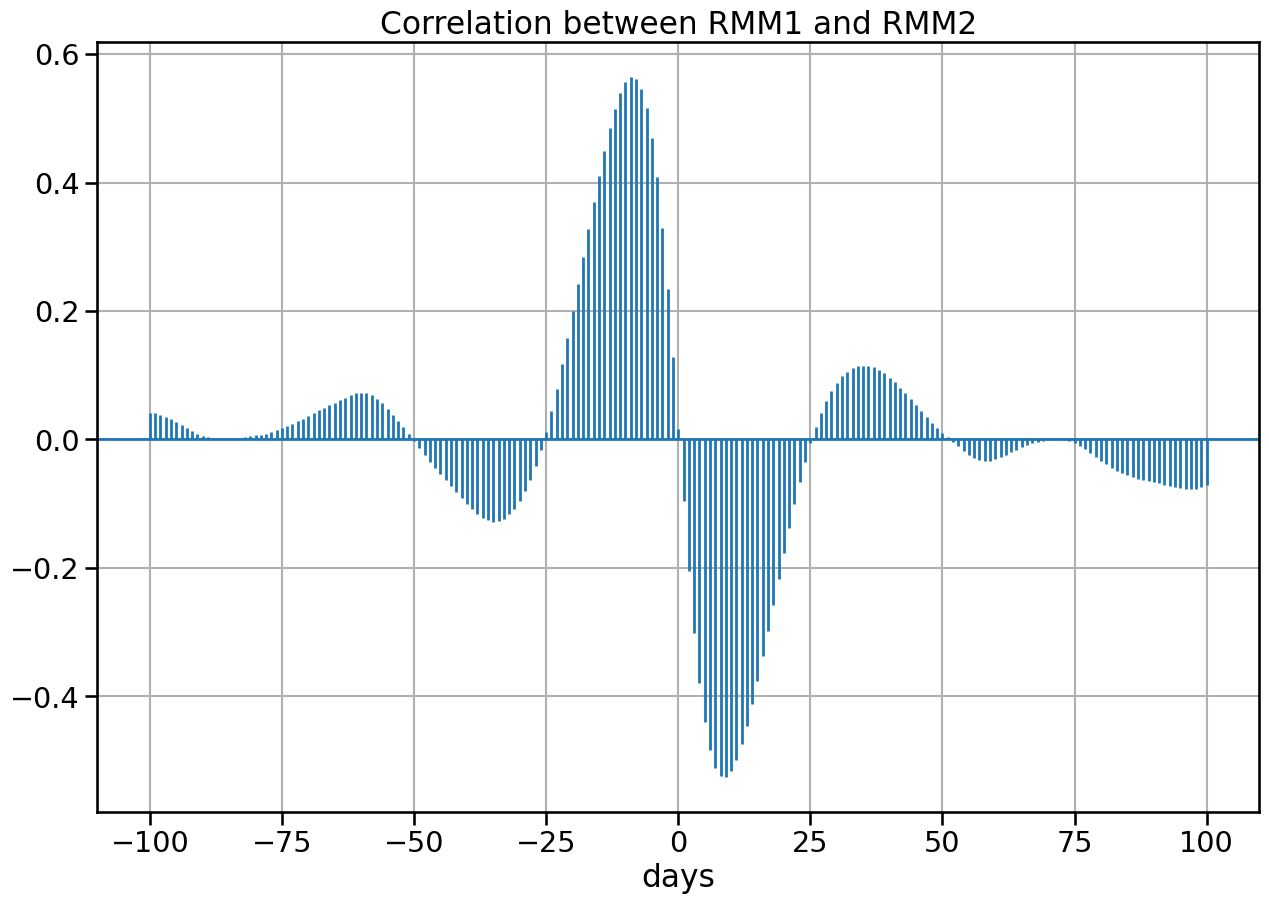

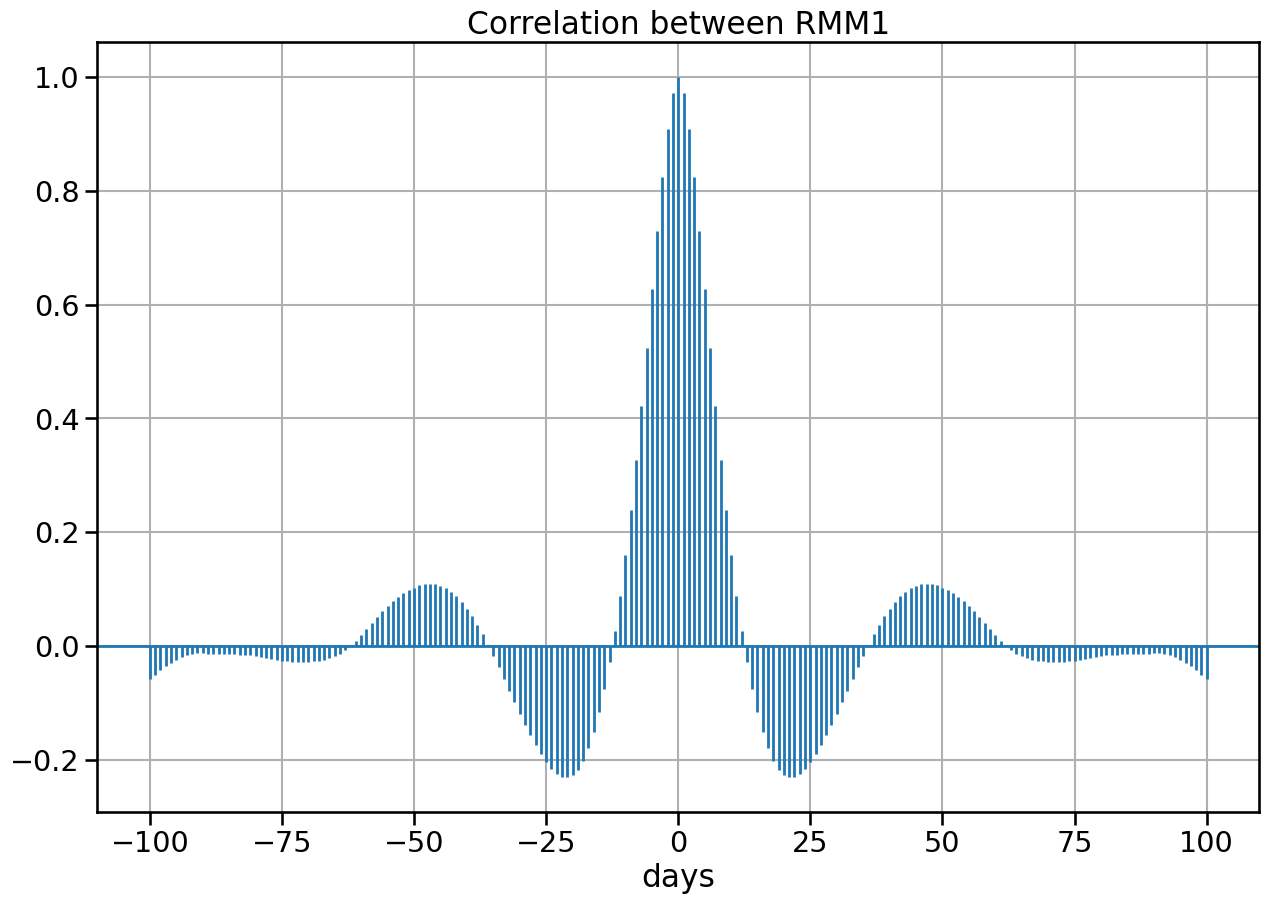

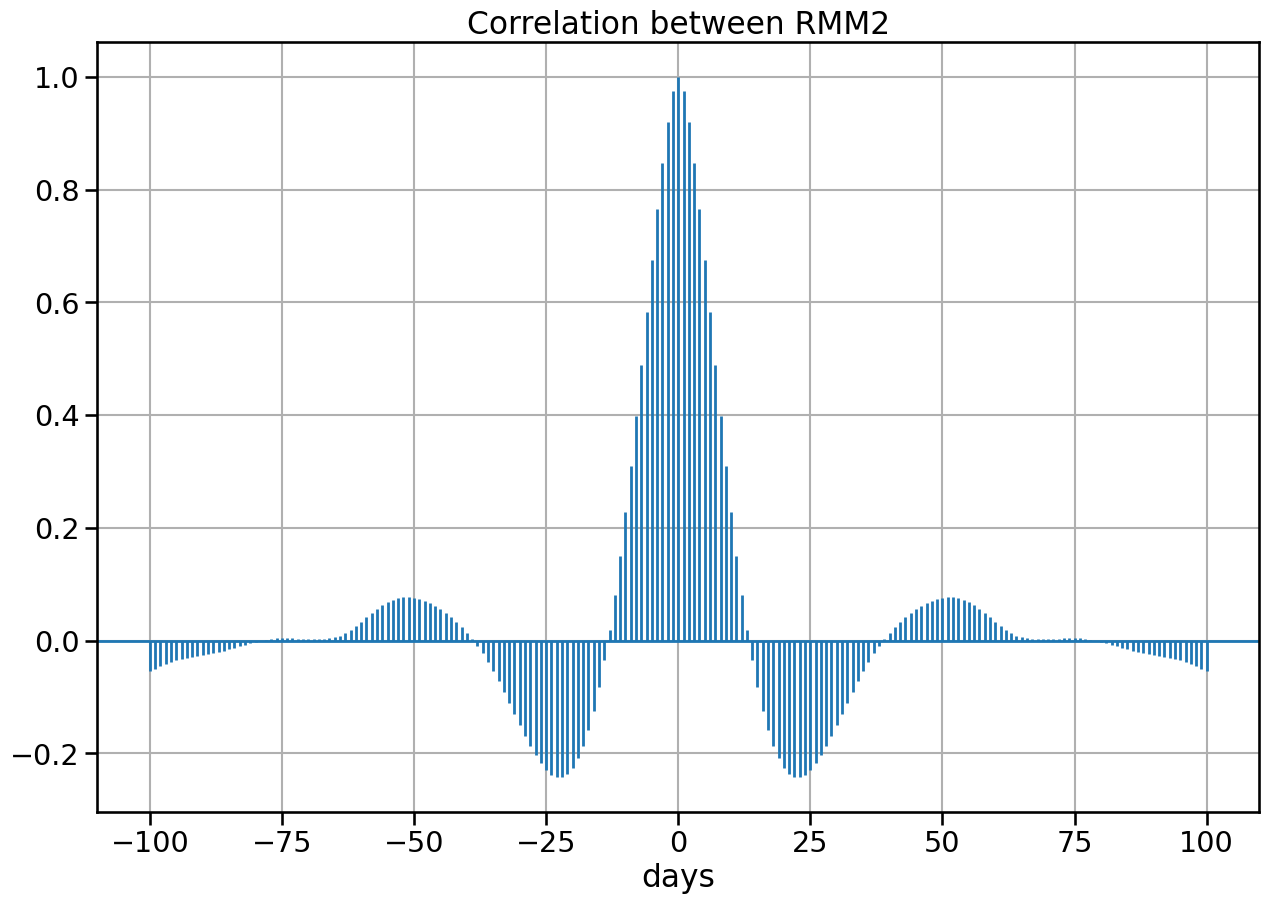

In [2]:
fig = plt.figure(figsize=(15, 10))
plt.xcorr(RMM1, RMM2, usevlines=True, maxlags=100, normed=True, lw=2)

plt.title("Correlation between RMM1 and RMM2")
plt.xlabel('days')
plt.grid('Both')
#plt.savefig('ac-rmm1-rmm2.png', bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(15, 10))
plt.acorr(RMM1, usevlines=True, maxlags=100, normed=True, lw=2)

plt.title("Correlation between RMM1")
plt.xlabel('days')
plt.grid('Both')
#plt.savefig('ac-short.png', bbox_inches='tight')
plt.show()

fig = plt.figure(figsize=(15, 10))
plt.acorr(RMM2, usevlines=True, maxlags=100, normed=True, lw=2)

plt.title("Correlation between RMM2")
plt.xlabel('days')
plt.grid('Both')
#plt.savefig('ac-short.png', bbox_inches='tight')
plt.show()



Compute mu and K
Compute mu
Compute K
Mean shapes:
mu1: (120,)
mu2: (2,)
Covariance shape:
K:   (122, 122)
K11: (120, 120)
K12: (120, 2)
K21: (2, 120)
K22: (2, 2)
Plotting K11


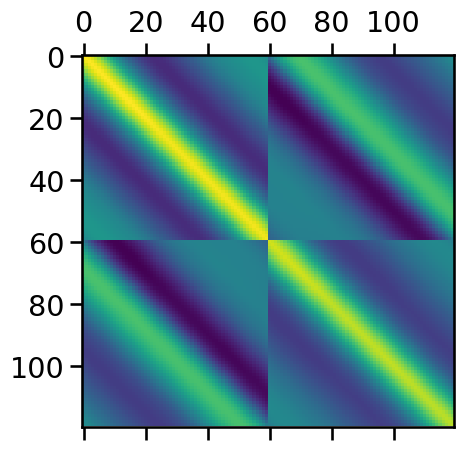

Computing matrices for kriging
Forming the prediction arrays


In [18]:
TEST=False
if(TEST):
    RMM1=np.arange(0,200)
    RMM2=np.arange(1000,1200)
    n = 5  # size of test data
    m = 1  # size of observed data
    N = 3  # size of training set
    P_buffer=5 # size of buffer between training and prediction
    P = 2  # size of prediction window
else:    
    n = 60   # size of test data
    m = 1    # size of observed data
    N = 1000 # size of training set
    P_buffer=100 # size of buffer between training and prediction
    P = 100 # size of prediction window
    
All_X=np.zeros((2*n,N))
All_Y=np.zeros((2*m,N))

for i in range(N):
    #this is test
    All_X[0:n,i]=RMM1[i:i+n]
    All_X[n:2*n,i]=RMM2[i:i+n]
    
    #this is observation
    All_Y[0:m,i]=RMM1[i+n]
    All_Y[m:2*m,i]=RMM2[i+n]

#these are combined
All_XY=np.concatenate([All_X,All_Y])

if(TEST):
    print(All_X.astype('int32'))
    print(All_Y.astype('int32'))
    print('-------')
    print(All_XY.astype('int32'))
    
print('Compute mu and K')

print('Compute mu')
XYmean=All_XY.mean(axis=1)

if(TEST):
    print('Mean:')
    print(XYmean)
    
print('Compute K')

XYcenter=All_XY-XYmean.reshape(2*n+2*m,1)

K=np.dot(XYcenter, XYcenter.T)/(N-1.)

if(TEST):
    print('K:')
    print(K)
    
    
mu1=XYmean[0:2*n]
mu2=XYmean[2*n:2*n+2*m]

print('Mean shapes:')
print('mu1: {:}'.format(mu1.shape))
print('mu2: {:}'.format(mu2.shape))

K11=K[0:2*n,0:2*n]
K12=K[0:2*n,2*n:2*n+2*m]
K21=K12.T
K22=K[2*n:2*n+2*m,2*n:2*n+2*m]

print('Covariance shape:')
print('K:   {:}'.format(K.shape))
print('K11: {:}'.format(K11.shape))
print('K12: {:}'.format(K12.shape))
print('K21: {:}'.format(K21.shape))
print('K22: {:}'.format(K22.shape))

print('Plotting K11')
plt.matshow(K11)
plt.show()

print('Computing matrices for kriging')
K11_inv=np.linalg.inv(K11)
K21_K11_inv=np.matmul(K21,K11_inv)
K21_K11_inv_K12=np.matmul(K21_K11_inv,K12)

KPred=K22-K21_K11_inv_K12 # this does not depend on the data 

print('Forming the prediction arrays')

index_start=n+N+P_buffer
index_end=n+N+P_buffer+P+n
RMM1_true_pred=RMM1[index_start:index_end]
RMM2_true_pred=RMM2[index_start:index_end]
X_start=np.zeros((2*n,))

#start with truth
X_start[0:n]=RMM1_true_pred[0:n]
X_start[n:2*n]=RMM2_true_pred[0:n]


X=X_start.copy()

Y=[]
#prediction coordinate (the index actually)
Coord_T=np.arange(n,n+P)
for i in range(P): 
    # this is the prediction
    Y.append(mu2 + np.matmul(K21_K11_inv, X - mu1))
    
    X[0:n-1]=X[1:n]
    X[n-1]=Y[i][0]
    
    X[n:2*n-1]=X[n+1:2*n]
    X[2*n-1]=Y[i][1]    
    
Y=np.asarray(Y)


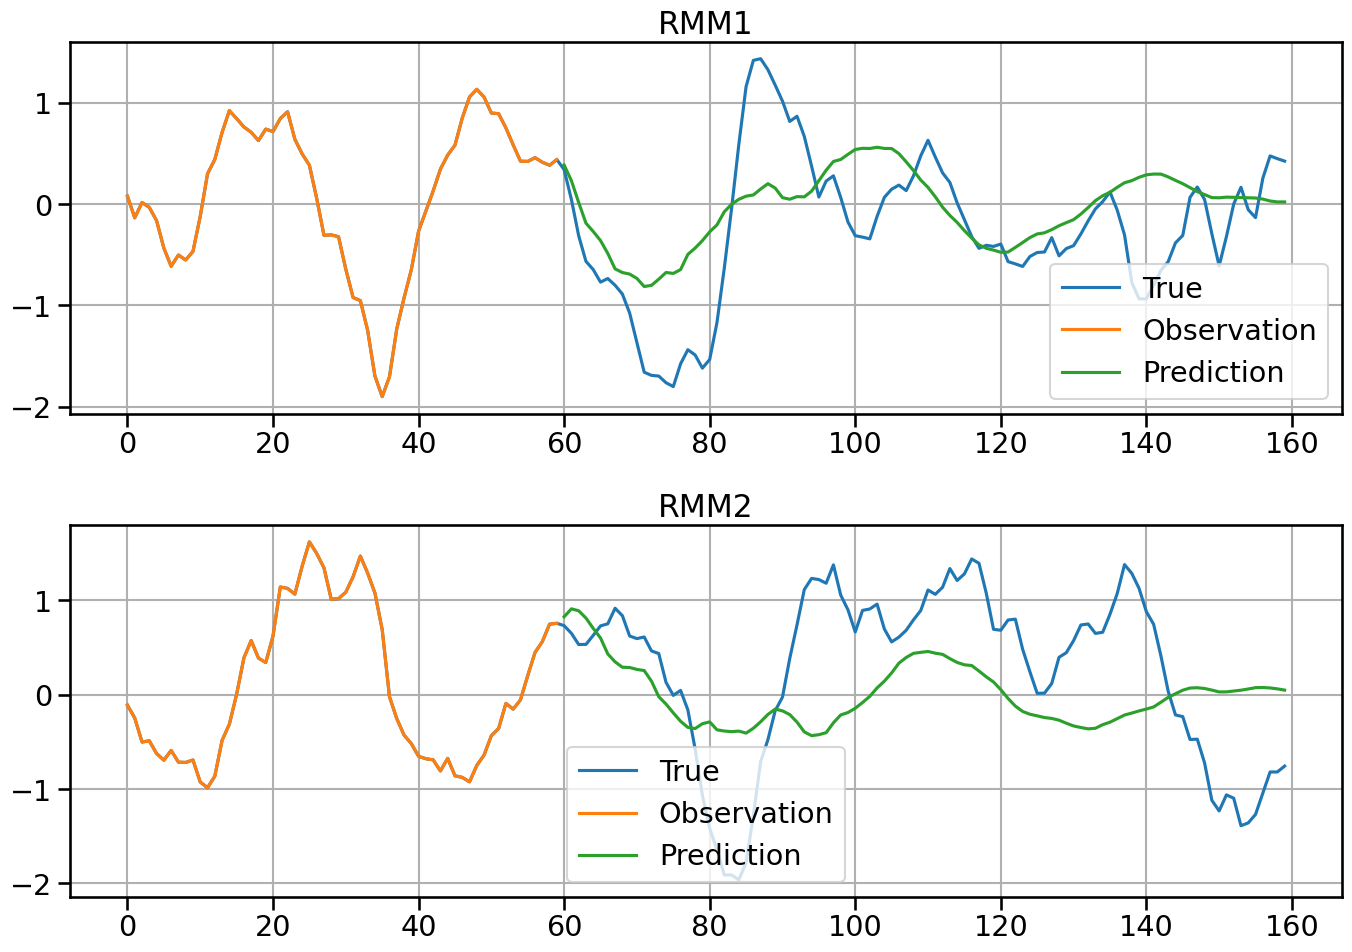

In [19]:
fig = plt.figure(figsize=(14, 10))
plt.subplot(2,1,1)
plt.plot(RMM1_true_pred,label='True')
plt.plot(X_start[0:n],label='Observation')
plt.plot(Coord_T,Y[0:P,0],label='Prediction')
plt.grid('both')
plt.legend()
plt.title('RMM1')
plt.tight_layout()

plt.subplot(2,1,2)
plt.plot(RMM2_true_pred,label='True')
plt.plot(X_start[n:2*n],label='Observation')
plt.plot(Coord_T,Y[0:P,1],label='Prediction')
plt.grid('both')
plt.legend()
plt.title('RMM2')
plt.tight_layout()

plt.show()